In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
import nltk
from nltk.tokenize import word_tokenize 

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('/content/drive/My Drive/Projects/GOT/got_scripts_breakdown.csv', delimiter=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [4]:
df = df[['Sentence']]
df.columns = ['Text']
df = df.iloc[:3000]
df.head()

,Text
0,What d’you expect? They’re savages One lot ste...
1,I’ve never seen wildlings do a thing like this...
2,How close did you get?
3,Close as any man would
4,We should head back to the wall


In [5]:
df.shape

(3000, 1)

In [6]:
def preprocess(text):
  text = text.lower()
  text = re.sub('[^a-z ]', ' ', text)
  text = text + ' endseq'
  text = ' '.join(text.split())
  return text

In [7]:
df['Text'] = df['Text'].apply(preprocess)
df.head()

,Text
0,what d you expect they re savages one lot stea...
1,i ve never seen wildlings do a thing like this...
2,how close did you get endseq
3,close as any man would endseq
4,we should head back to the wall endseq


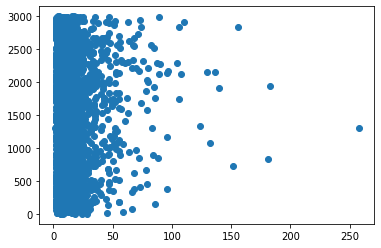

In [8]:
sen_length = [len(x) for x in df.Text.str.split()]
plt.scatter(sen_length, [i for i in range(len(sen_length))])
plt.show()

In [9]:
df = df[np.array(sen_length) <= 200]
df.reset_index(inplace = True)
df.shape

(2999, 2)

In [10]:
vocab = []

for i in df.Text:
  vocab.append(word_tokenize(i))

In [11]:
vocab_flat = []

for sublist in vocab:
    for item in sublist:
        vocab_flat.append(item)

print('Total words:', len(vocab_flat), '| Unique words:', len(set(vocab_flat)))

Total words: 41923 | Unique words: 3658


In [12]:
max_sentence = max([len(x) for x in vocab])
max_sentence

183

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer(num_words=len(set(vocab_flat)), filters = '')
t.fit_on_texts(set(vocab_flat))
sequences = t.texts_to_sequences(df.Text.tolist())

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences, maxlen = max_sentence)
del sequences
print(padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1537 2120 3551 3273 1175 2933 1541 1887 3204 2878 2789 2794 2932
 3087 3204   34 2957 3551  610 2941 1175 2933  644 1908 1660 2284 3161
 1103]


In [15]:
def make_X_y(max_sentence, padded):
  X = []; y = []
  for i in tqdm(range(len(padded))):
    for j in range(1, max_sentence):
        X.append(pad_sequences([padded[i][0:j]], maxlen = max_sentence)[0])
        y.append(padded[i][j])
  return X, y

In [16]:
import gc
gc.collect()

279

In [17]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.3.177.194:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.3.177.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.177.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [18]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.regularizers import l2

In [19]:
with strategy.scope():
  model = Sequential()
  model.add(Input(shape = (max_sentence,)))
  model.add(Embedding(input_dim = len(set(vocab_flat)), output_dim = 128, mask_zero = True))
  model.add(LSTM(units = 128, activation='relu'))
  model.add(Dense(units = len(t.word_index), activation = 'softmax'))

In [20]:
with strategy.scope():
  model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy())

In [21]:
from tqdm import tqdm_notebook as tqdm
batchSize = 512
length = df.shape[0]
training_size = 0
count = 0
for i in range(0, length, batchSize):
  if count == 2:
    break
  gc.collect()
  X, y = make_X_y(max_sentence, padded[i : i + batchSize])
  
  X = np.array(X)
  assert not np.any(np.isnan(X))

  y = to_categorical(y, dtype = 'bool', num_classes= len(set(vocab_flat)))
  y = np.array(y)
  print(X.shape)
  print(y.shape)
  model.fit(X, y, epochs = 50, batch_size=1024)
  training_size += X.shape[0]
  count += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



(93184, 183)
(93184, 3658)
Epoch 1/50
91/91 [==============================] - 3s 32ms/step - loss: 8.1256
Epoch 2/50
91/91 [==============================] - 3s 31ms/step - loss: 8.1109
Epoch 3/50
91/91 [==============================] - 3s 31ms/step - loss: 7.7282
Epoch 4/50
91/91 [==============================] - 3s 31ms/step - loss: 7.5170
Epoch 5/50
91/91 [==============================] - 3s 31ms/step - loss: 7.3373
Epoch 6/50
91/91 [==============================] - 3s 32ms/step - loss: 7.1658
Epoch 7/50
91/91 [==============================] - 3s 32ms/step - loss: 6.9970
Epoch 8/50
91/91 [==============================] - 3s 32ms/step - loss: 6.8288
Epoch 9/50
91/91 [==============================] - 3s 32ms/step - loss: 6.6598
Epoch 10/50
91/91 [==============================] - 3s 32ms/step - loss: 6.4910
Epoch 11/50
91/91 [==============================] - 3s 32ms/step - loss: 6.3227
Epoch 12/50
91/91 [==============================] - 3s 32ms/step - loss: 6.1547
Epoch 13/


(93184, 183)
(93184, 3658)
Epoch 1/50
91/91 [==============================] - 3s 31ms/step - loss: 1.2665
Epoch 2/50
91/91 [==============================] - 3s 32ms/step - loss: 1.0635
Epoch 3/50
91/91 [==============================] - 3s 32ms/step - loss: 1.0002
Epoch 4/50
91/91 [==============================] - 3s 31ms/step - loss: 0.9493
Epoch 5/50
91/91 [==============================] - 3s 31ms/step - loss: 0.9051
Epoch 6/50
91/91 [==============================] - 3s 31ms/step - loss: 0.8656
Epoch 7/50
91/91 [==============================] - 3s 32ms/step - loss: 0.8299
Epoch 8/50
91/91 [==============================] - 3s 32ms/step - loss: 0.7970
Epoch 9/50
91/91 [==============================] - 3s 31ms/step - loss: 0.7664
Epoch 10/50
91/91 [==============================] - 3s 31ms/step - loss: 0.7371
Epoch 11/50
91/91 [==============================] - 3s 31ms/step - loss: 0.7092
Epoch 12/50
91/91 [==============================] - 3s 32ms/step - loss: 0.6821
Epoch 13/

In [22]:
print('Total training size model is trained on:', training_size)

Total training size model is trained on: 186368
